In [15]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [16]:
class Config:
    seq_len = 1024
    vocab_capacity = 10000

In [17]:

real_news = pd.read_csv("true.csv")
real_news["label"] = 0.0
fake_news = pd.read_csv("fake.csv")
fake_news["label"] = 1.0
news_dataset = pd.concat([real_news, fake_news])
news_dataset.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0.0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0.0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0.0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0.0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0.0


<Axes: xlabel='label'>

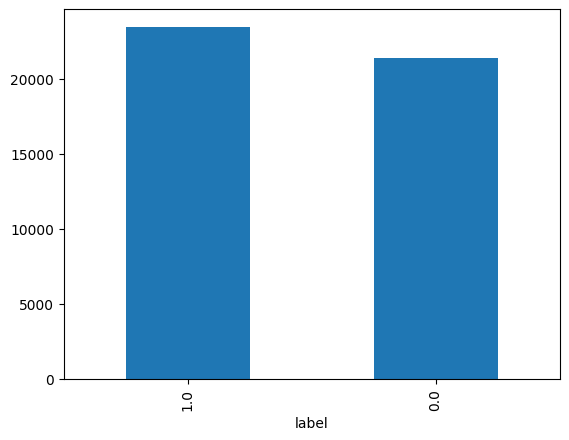

In [18]:
news_dataset.label.value_counts().plot(kind="bar")


In [19]:
news_dataset["headline_len"] = news_dataset["title"].apply(lambda t: len(t.split(" ")))
news_dataset["article_len"] = news_dataset["text"].apply(lambda txt: len(txt.split(" ")))


In [20]:
news_dataset[["headline_len", "article_len"]].describe()


,headline_len,article_len
count,44898.000000,44898.000000
mean,12.657245,415.760412
std,4.170713,361.648003
min,1.000000,1.000000
25%,10.000000,208.000000
50%,12.000000,371.000000
75%,15.000000,525.000000
max,45.000000,8436.000000


<Axes: ylabel='Frequency'>

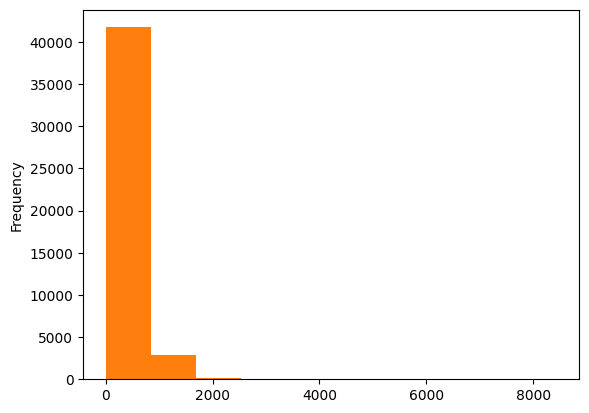

In [21]:
news_dataset["headline_len"].plot(kind="hist")
news_dataset["article_len"].plot(kind="hist")

In [22]:
train_set, validation_set = train_test_split(news_dataset, test_size=0.2, stratify=news_dataset["label"], random_state=42)
train_set.shape, validation_set.shape

((35918, 7), (8980, 7))

In [23]:

def build_tf_dataset(df, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((df["text"], df["label"]))
    if shuffle:
        dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.batch(256).cache().prefetch(tf.data.AUTOTUNE)
    return dataset


In [24]:
train_dataset = build_tf_dataset(train_set)
valid_dataset = build_tf_dataset(validation_set, shuffle=False)


In [25]:
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=Config.vocab_capacity, 
    output_sequence_length=Config.seq_len, 
    pad_to_max_tokens=True
)
vectorize_layer.adapt(news_dataset["text"], batch_size=1024)


In [26]:
classifier_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    vectorize_layer,
    tf.keras.layers.Embedding(
        input_dim=Config.vocab_capacity, 
        output_dim=64,
        input_length=Config.seq_len, 
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), 
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
classifier_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), 
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
    metrics=[
        "accuracy", 
        tf.keras.metrics.AUC(name="auc")
    ]
)
classifier_model.summary()
tf.keras.utils.plot_model(classifier_model)

checkpoint_path = "classifier_model.keras"
train_history = classifier_model.fit(
    train_dataset, 
    epochs=1, 
    validation_data=valid_dataset,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            checkpoint_path,
            save_best_only=True,
            monitor='val_accuracy',
            mode='max'
        )
    ]
)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, 1024)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 1024, 64)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 1024, 128)      │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 748,321 (2.85 MB)

 Trainable params: 748,321 (2.85 MB)

 Non-trainable params: 0 (0.00 B)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
141/141 ━━━━━━━━━━━━━━━━━━━━ 861s 6s/step - accuracy: 0.9071 - auc: 0.9686 - loss: 0.2533 - val_accuracy: 0.9987 - val_auc: 0.9995 - val_loss: 0.0147


In [29]:
# def visualize_training_progress(history):
#     plt.figure(figsize=(12, 8))
    
#     if 'loss' in history.history and 'val_loss' in history.history:
#         plt.plot(history.history['loss'], label="Training Loss")
#         plt.plot(history.history['val_loss'], label="Validation Loss")
#         plt.title('Loss')
#         plt.ylabel('Loss')
#         plt.xlabel('Epoch')
#         plt.legend(loc='upper right')
#         plt.show()

#     if 'accuracy' in history.history and 'val_accuracy' in history.history:
#         plt.figure(figsize=(12, 8))
#         plt.plot(history.history['accuracy'], label="Training Accuracy")
#         plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
#         plt.title('Accuracy')
#         plt.ylabel('Accuracy')
#         plt.xlabel('Epoch')
#         plt.legend(loc='upper right')
#         plt.show()

#     if 'auc' in history.history and 'val_auc' in history.history:
#         plt.figure(figsize=(12, 8))
#         plt.plot(history.history['auc'], label="Training AUC")
#         plt.plot(history.history['val_auc'], label="Validation AUC")
#         plt.title('AUC')
#         plt.ylabel('AUC')
#         plt.xlabel('Epoch')
#         plt.legend(loc='upper right')
#         plt.show()

# visualize_training_progress(train_history)
